## DHIA SALSABILA AZHAR
## 18/430187/PA/18700

link colab 

https://colab.research.google.com/drive/1wwmhbPb33DDJ0GeHy3fChgNmitHYVyIX?usp=sharing

## 1. Load Data dari Directory

Data yang diambil berasal dari link github

In [ ]:
!git clone https://github.com/aljovanmp518/Face_dataset

fatal: destination path 'Face_dataset' already exists and is not an empty directory.


## 2. Import Library yang akan digunakan

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

Membuat path dari dataset yang di simpan di dalam variabel data_dir

In [ ]:
data_dir = '/content/Face_dataset/face'

## 3. Mendeklarasikan Data 

Mendeklarasi batch size dan image size yang akan digunakan

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## 4. Split Dataset
Menggunakan hanya 80% untuk data training dan 20% untuk data validasi menggunakan validasi split

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5775 files belonging to 2 classes.
Using 4620 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5775 files belonging to 2 classes.
Using 1155 files for validation.


Melihat nama kelas yang ada pada dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Negative', 'Positive']


## 5. Visualisasi Data

Data yang di tampilkan hanya 3 baris dan 3 kolom atau sejumlah 9 citra pertama karena hanya digunakan untuk melihat beberapa data yang ada di dalam dataset

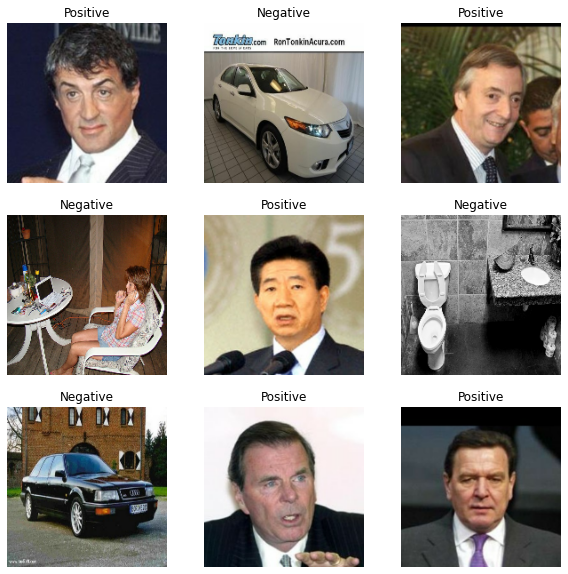

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Image_batch adalah tensor flow (32, 180, 180, 3) maksudnya ada kumpulan 32 gambar dengan bentuk 180x180x3 (dimensi terakhir mengacu pada saluran warna RGB). Label_batch adalah tensor flow (32,), ini adalah label yang sesuai dengan 32 gambar.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Dataset.cache () : menyimpan gambar dalam memori setelah dimuat dari disk selama epoch pertama. Ini akan memastikan set data tidak menjadi hambatan saat melatih model. Jika kumpulan data terlalu besar untuk dimasukkan ke dalam memori, dapat menggunakan metode ini untuk membuat cache pada disk yang berkinerja baik.

Dataset.prefetch () : tumpang tindih dengan pemrosesan awal data dan eksekusi model saat pelatihan.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 6. Normalisasi Data

Nilai channel RGB berada dalam kisaran [0, 255], merupakan nilai yang tidak ideal untuk jaringan saraf. 
Secara umum nilai masukan harus kecil. Nilai akan distandarisasi sehingga berada dalam kisaran [0, 1] dengan menggunakan lapisan Rescaling

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 7. Membuat Model

Model ini terdiri dari tiga blok konvolusi dengan masing-masing layer Max Pool. Ada lapisan yang sepenuhnya terhubung dengan 128 unit di atasnya yang diaktifkan oleh fungsi aktivasi relu. 
Untuk menghindari overfitting diberi layer Dropout 0.2

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

## 8. Meng-compile Model

Digunakan optimizer Adam, fungsi loss sparse categorical crossentropy dan fungsi metrics untuk melihat performa melalui tampilan loss dan akurasi model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 9. Training Model

Model ditraining dengan jumlah epoch 10 

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
145/145 [==============================] - 144s 994ms/step - loss: 0.1662 - accuracy: 0.9368 - val_loss: 0.0597 - val_accuracy: 0.9758
Epoch 2/10
145/145 [==============================] - 145s 1s/step - loss: 0.0237 - accuracy: 0.9909 - val_loss: 0.0199 - val_accuracy: 0.9922
Epoch 3/10
145/145 [==============================] - 145s 997ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0114 - val_accuracy: 0.9974
Epoch 4/10
145/145 [==============================] - 144s 990ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 5/10
145/145 [==============================] - 143s 986ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0111 - val_accuracy: 0.9965
Epoch 6/10
145/145 [==============================] - 143s 985ms/step - loss: 8.8318e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9965
Epoch 7/10
145/145 [==============================] - 142s 976ms/step - loss: 1.9306e-04 - accuracy: 1.0000 - val_loss: 0.0

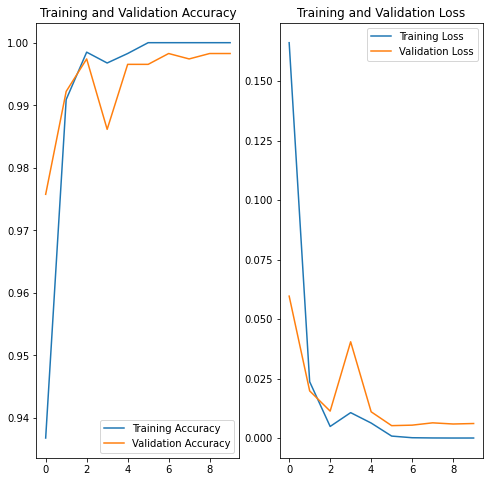

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(val_ds)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Positive with a 100.00 percent confidence.
